In [ ]:
# Pin a clean, compatible stack and FORCE a runtime restart
%pip install -q \
  numpy==1.26.4 \
  scipy==1.11.4 \
  pandas==2.2.2 \
  statsmodels==0.14.2 \
  yfinance==0.2.52 \
  matplotlib==3.9.0

import IPython
IPython.Application.instance().kernel.do_shutdown(True)  # auto-restarts runtime


In [2]:
# Clean, Colab-compatible pin set (no pmdarima)
!pip install -q \
  numpy==1.26.4 \
  scipy==1.11.4 \
  pandas==2.2.2 \
  scikit-learn==1.5.2 \
  statsmodels==0.14.2 \
  tensorflow==2.17.0 \
  yfinance==0.2.52 \
  seaborn==0.13.2

import IPython
IPython.Application.instance().kernel.do_shutdown(True)  # <-- restarts runtime


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.17.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tensorflow-tex

{'status': 'ok', 'restart': True}

# GMF — Task 2: Modeling (ARIMA via statsmodels & LSTM) for TSLA

*Colab-friendly, no `pmdarima` required.*

In [2]:
# === Google Drive Persistence ===
from google.colab import drive
drive.mount('/content/drive')

import os

# 👉  project path here
os.environ["GMF_DRIVE_PROJECT_DIR"] = "/content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization"

BASE_DIR   = os.environ["GMF_DRIVE_PROJECT_DIR"]
DATA_DIR   = os.path.join(BASE_DIR, "data")
OUT_PLOTS  = os.path.join(BASE_DIR, "outputs", "plots")
OUT_MODELS = os.path.join(BASE_DIR, "outputs", "models")
OUT_METRICS= os.path.join(BASE_DIR, "outputs", "metrics")

for d in [DATA_DIR, OUT_PLOTS, OUT_MODELS, OUT_METRICS]:
    os.makedirs(d, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)

Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization
DATA_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/data


In [8]:
# === Config & Data Loading ===
import pandas as pd, numpy as np, os

START_DATE = "2015-07-01"
END_DATE   = "2025-07-31"
TRAIN_END  = "2023-12-31"
TEST_START = "2024-01-01"
TEST_END   = "2025-07-31"

# Ensure combined CSVs exist; build from per-ticker if needed
prices_path  = os.path.join(DATA_DIR, "prices_adj_close.csv")
returns_path = os.path.join(DATA_DIR, "returns_daily.csv")

def load_adj_close(csv_path: str) -> pd.Series:
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    col = None
    for c in ["Adj Close","AdjClose","Adj_Close","Adjclose"]:
        if c in df.columns:
            col = c; break
    if col is None: raise ValueError(f"'Adj Close' not in {csv_path}: {list(df.columns)}")
    s = df[col].astype(str).str.replace(",","", regex=False).str.strip()
    s = pd.to_numeric(s, errors="coerce")
    s.name = os.path.basename(csv_path).split("_")[0]
    return s

if not (os.path.exists(prices_path) and os.path.exists(returns_path)):
    print("Combined CSVs not found. Attempting to build from per-ticker files...")
    paths = {
        "TSLA": os.path.join(DATA_DIR, "TSLA_1d.csv"),
        "BND":  os.path.join(DATA_DIR, "BND_1d.csv"),
        "SPY":  os.path.join(DATA_DIR, "SPY_1d.csv"),
    }
    miss = [tk for tk,p in paths.items() if not os.path.exists(p)]
    if miss: raise FileNotFoundError(f"Missing per-ticker files: {miss} -> run GMF_01 first.")
    adj = [load_adj_close(paths[tk]) for tk in ["TSLA","BND","SPY"]]
    prices = pd.concat(adj, axis=1).sort_index().ffill().dropna(how="any")
    prices.to_csv(prices_path)
    returns = prices.pct_change(fill_method=None).dropna(how="any")
    returns.to_csv(returns_path)
    print("Created combined CSVs.")
else:
    prices  = pd.read_csv(prices_path, index_col=0, parse_dates=True)
    returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)

display(prices.tail(), returns.tail())

tsla = prices["TSLA"].dropna()
train = tsla.loc[:TRAIN_END]
test  = tsla.loc[TEST_START:TEST_END]

print("Train:", train.index.min(), "→", train.index.max(), "| Test:", test.index.min(), "→", test.index.max(), f"(n_test={len(test)})")

,TSLA,BND,SPY
Price,,,
2025-07-28,325.589996,72.758659,636.940002
2025-07-29,321.200012,73.137398,635.260010
2025-07-30,319.040009,72.948036,634.460022
Date,319.040009,72.948036,634.460022
Ticker,319.040009,72.948036,634.460022


,TSLA,BND,SPY
Price,,,
2025-07-28,0.030152,-0.001641,-0.000251
2025-07-29,-0.013483,0.005205,-0.002638
2025-07-30,-0.006725,-0.002589,-0.001259
Date,0.000000,0.000000,0.000000
Ticker,0.000000,0.000000,0.000000


Train: 2015-07-01 → 2023-12-29 | Test: 2024-01-02 → 2025-07-30 (n_test=395)


## ARIMA (statsmodels SARIMAX)

Train_b: 2015-07-01 00:00:00 → 2023-12-29 00:00:00 | Test_b: 2024-01-01 00:00:00 → 2025-07-30 00:00:00 (n_test=413)
Chosen (p,d,q): (0, 1, 2) | AIC: 14050.478026190205


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SARIMAX → MAE: 63.73 | RMSE: 79.00 | MAPE: 24.17%


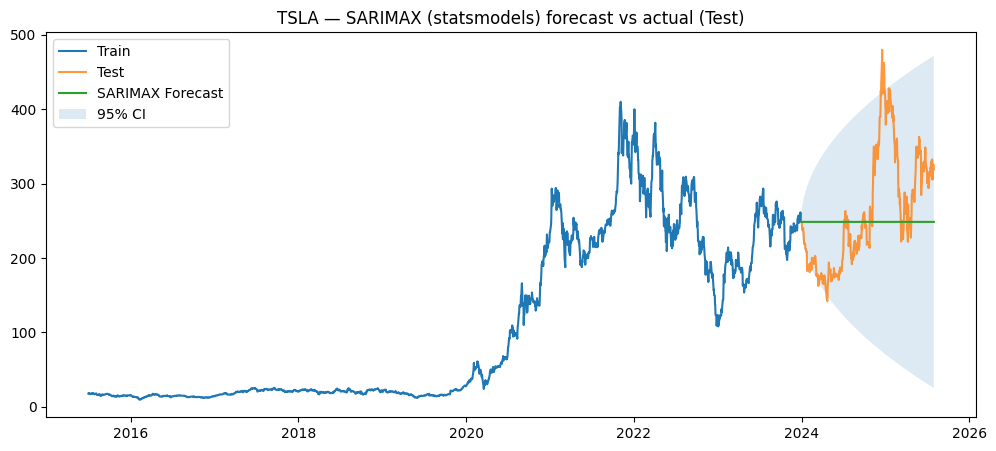

['/content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/models/tsla_arima_statsmodels.pkl']

In [10]:
# --- Clean ARIMA (statsmodels SARIMAX) on business-day indexed TSLA ---
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===== config / paths (keeps prior values if already set) =====
TRAIN_END  = globals().get("TRAIN_END",  "2023-12-31")
TEST_START = globals().get("TEST_START", "2024-01-01")
TEST_END   = globals().get("TEST_END",   "2025-07-31")
OUT_PLOTS  = globals().get("OUT_PLOTS",  os.path.join(BASE_DIR, "outputs", "plots"))
OUT_MODELS = globals().get("OUT_MODELS", os.path.join(BASE_DIR, "outputs", "models"))
os.makedirs(OUT_PLOTS, exist_ok=True)
os.makedirs(OUT_MODELS, exist_ok=True)

# ===== build a clean TSLA series with real DatetimeIndex and floats =====
# If 'prices' exists, ensure its index is datetime and pull TSLA from there
if "prices" in globals():
    prices.index = pd.to_datetime(prices.index, errors="coerce")
    prices = prices.sort_index()
    tsla_raw = prices["TSLA"]
else:
    # Fall back to previously defined 'tsla'
    tsla_raw = tsla

# Coerce index → datetime, values → numeric
idx = pd.to_datetime(tsla_raw.index, errors="coerce")
val = pd.to_numeric(pd.Series(tsla_raw).values, errors="coerce")

mask = (~pd.isna(idx)) & (~pd.isna(val))
tsla_num = pd.Series(val[mask], index=idx[mask]).sort_index()
tsla_num.index.name = "Date"
if tsla_num.empty:
    raise ValueError("TSLA series empty after cleaning—check your inputs.")

# Reindex to business days to supply a frequency and ffill small gaps
bd_index = pd.bdate_range(tsla_num.index.min(), tsla_num.index.max(), freq="B")
tsla_b = tsla_num.reindex(bd_index).ffill()
tsla_b.index.name = "Date"

# Chronological split on the BD-indexed series
train_b = tsla_b.loc[:TRAIN_END]
test_b  = tsla_b.loc[TEST_START:TEST_END]
print("Train_b:", train_b.index.min(), "→", train_b.index.max(),
      "| Test_b:", test_b.index.min(), "→", test_b.index.max(),
      f"(n_test={len(test_b)})")

# ===== fit SARIMAX over a small, stable candidate set =====
candidates = [(0,1,1), (0,1,2), (1,1,1), (2,1,1)]
best_aic, best_order, best_res = np.inf, None, None
for order in candidates:
    try:
        res = sm.tsa.SARIMAX(
            train_b,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(maxiter=500, disp=False)
        if res.aic < best_aic:
            best_aic, best_order, best_res = res.aic, order, res
    except Exception:
        pass

if best_res is None:
    raise RuntimeError("SARIMAX failed for all candidate (p,d,q). Try expanding candidates.")

print("Chosen (p,d,q):", best_order, "| AIC:", best_aic)

# ===== forecast; align to test index to avoid NaNs in metrics =====
n_test = len(test_b)
pred = best_res.get_forecast(steps=n_test)
fc_mean = pd.Series(pred.predicted_mean.values, index=test_b.index, name="ARIMA_FC")
conf_df = pred.conf_int()
conf_df.index = test_b.index  # align intervals to test dates

# Metrics with alignment & NaN guard
aligned = pd.concat([test_b.rename("actual"), fc_mean], axis=1).dropna()
mae  = mean_absolute_error(aligned["actual"], aligned["ARIMA_FC"])
rmse = mean_squared_error(aligned["actual"], aligned["ARIMA_FC"], squared=False)
mape = (np.abs((aligned["actual"] - aligned["ARIMA_FC"]) / aligned["actual"])).mean() * 100
print(f"SARIMAX → MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12,5))
plt.plot(train_b.index, train_b, label="Train")
plt.plot(test_b.index,  test_b,  label="Test", alpha=0.8)
plt.plot(fc_mean.index,  fc_mean, label="SARIMAX Forecast")
plt.fill_between(test_b.index, conf_df.iloc[:, 0], conf_df.iloc[:, 1], alpha=0.15, label="95% CI")
plt.title("TSLA — SARIMAX (statsmodels) forecast vs actual (Test)")
plt.legend()
plt.savefig(os.path.join(OUT_PLOTS, "arima_test_statsmodels.png"))
plt.show()

# Save model for Task 3 reuse
joblib.dump(best_res, os.path.join(OUT_MODELS, "tsla_arima_statsmodels.pkl"))


## LSTM Baseline

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.0281 - mae: 0.1008 - val_loss: 0.0035 - val_mae: 0.0432
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0033 - val_mae: 0.0416
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0020 - mae: 0.0268 - val_loss: 0.0028 - val_mae: 0.0385
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0015 - mae: 0.0220 - val_loss: 0.0024 - val_mae: 0.0366
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0025 - val_mae: 0.0358
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0027 - val_mae: 0.0375
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0015 - mae: 0.0221 - val_loss: 0.0023 - val_mae: 0.0349
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0014 - mae: 0.0214 - val_loss: 0.0024 - val_mae: 0.0351
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


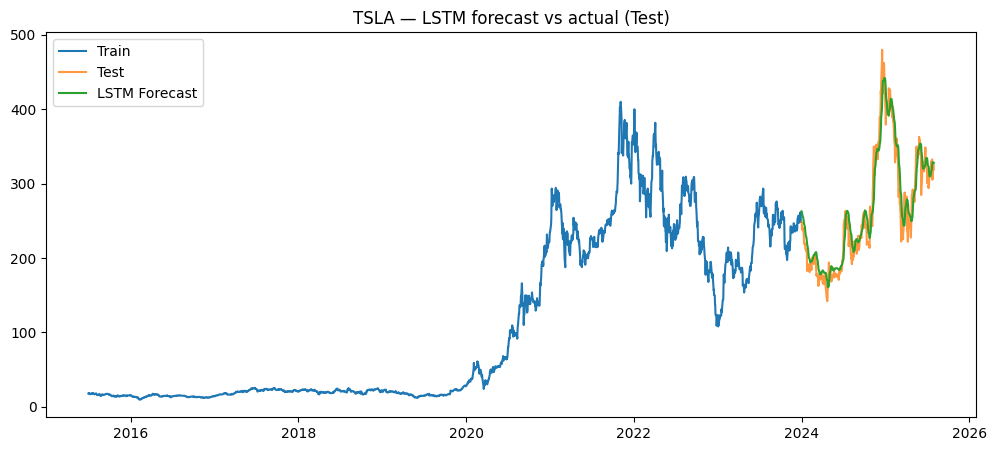

Saved: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/outputs/metrics/task2_metrics.json


In [12]:
# --- LSTM on business-day TSLA, aligned with ARIMA splits ---
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Use the cleaned, business-day series from the ARIMA cell
ts_for_nn = tsla_b.copy()

# Recompute split on the BD series (same dates)
split_idx_b = ts_for_nn.index.get_indexer([pd.Timestamp(TRAIN_END)], method="pad")[0] + 1
train_nn = ts_for_nn.iloc[:split_idx_b]
test_nn  = ts_for_nn.loc[TEST_START:TEST_END]

# Scale entire series
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_for_nn.values.reshape(-1,1))

lookback = 60
def make_seq(arr, lookback=60):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i, 0])
    X = np.array(X); y = np.array(y)
    return X[..., None], y

# Build sequences: note the test window starts at split_idx_b - lookback
X_train, y_train = make_seq(ts_scaled[:split_idx_b], lookback)
X_test,  y_test  = make_seq(ts_scaled[split_idx_b - lookback:], lookback)

# Model
model = keras.Sequential([
    layers.Input(shape=(lookback,1)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
hist = model.fit(X_train, y_train, epochs=10, batch_size=32,
                 validation_data=(X_test, y_test), verbose=1)

# Predict and invert scale
yhat_scaled = model.predict(X_test).ravel()
yhat = scaler.inverse_transform(yhat_scaled.reshape(-1,1)).ravel()

# Align prediction index with test (NO extra [lookback:] slice)
pred_index = ts_for_nn.index[split_idx_b:]

# Safety: truncate both to same length
n = min(len(yhat), len(pred_index))
yhat = yhat[:n]
pred_index = pred_index[:n]

lstm_fc = pd.Series(yhat, index=pred_index, name="LSTM_FC")

# Align actuals to prediction window
test_aligned = ts_for_nn.loc[pred_index.min():pred_index.max()]

# Metrics
mae_l  = mean_absolute_error(test_aligned, lstm_fc)
rmse_l = mean_squared_error(test_aligned, lstm_fc, squared=False)
mape_l = (np.abs((test_aligned - lstm_fc)/test_aligned)).mean()*100
print(f"LSTM → MAE: {mae_l:.2f} | RMSE: {rmse_l:.2f} | MAPE: {mape_l:.2f}%")

# Plot
plt.figure(figsize=(12,5))
plt.plot(train_b.index, train_b, label="Train")
plt.plot(test_b.index,  test_b,  label="Test", alpha=0.8)
plt.plot(lstm_fc.index,  lstm_fc, label="LSTM Forecast")
plt.title("TSLA — LSTM forecast vs actual (Test)"); plt.legend()
plt.savefig(os.path.join(OUT_PLOTS, "lstm_test.png")); plt.show()

# Save
model.save(os.path.join(OUT_MODELS, "tsla_lstm.h5"))

# (Optional) update task2 metrics file if ARIMA metrics available in scope
try:
    metrics = {
        "ARIMA_statsmodels": {"MAE": float(mae), "RMSE": float(rmse), "MAPE": float(mape)},
        "LSTM": {"MAE": float(mae_l), "RMSE": float(rmse_l), "MAPE": float(mape_l)}
    }
    import json
    with open(os.path.join(OUT_METRICS, "task2_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print("Saved:", os.path.join(OUT_METRICS, "task2_metrics.json"))
except NameError:
    pass  # ARIMA metrics not in scope; skip writing combined JSON
